### Notebook for Testing Trained Models  
Cells are run sequentially:  
    **~ Cell 1**: Importing libraries, ensure correct filepath to the models.  
    **~ Cell 2**: Importing model, `supervised_import` determines whether to import a supervised model or semi-supervised model,   
    ...then the specific run can be selected by with the corresponding index as the `run_number`, or specifying the supervised run name.  
    **~ Cell 3**: Generate test data, parameters of the test data can be varied and distributions plotted.  
    **~ Cell 4**: Compute the Ricci tensors for the loaded model on the test data.  
    **~ Cell 5**: Plot visualisations of the loaded model metrics and computed Ricci tensors on the test data. Plotting parameters can be  
    ...edited, including setting the `plot_radial_limit` to reduce to the patch portions used for the global manifold definition.  
    **~ Cell 6**: Compute the Global test loss for the loaded model on the test data, printing components.  
    **~ Cell 7**: Plot visualisations of analytic metrics, either the identity initialisation or analytic round metric.  

In [47]:
# Import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
import tensorflow_probability as tfp
tf.keras.backend.set_floatx('float64')

# Import relevant functions
from helper_functions.helper_functions import cholesky_from_vec, plot_fig
from sampling.ball import BallSample, CubeSample
from network.base import GlobalConformalModel_L2
from network.ball import BallGlobalModel, BallPatchSubModel
from geometry.common import compute_ricci_tensor
from geometry.ball import PatchChange_Coordinates_Ball, PatchChange_Metric_Ball, AnalyticMetric_Ball
from losses.ball import GlobalLossBall

# Output the list of saved semi-supervised runs (to select which to import with in the following cell)
root_runs_path = os.getcwd()+"/runs/" #...set the correct filepath
saved_runs = [run for run in os.listdir(root_runs_path) if os.path.isdir(os.path.join(root_runs_path, run))]
for run_name_idx, run_name in enumerate(saved_runs):
    print(run_name_idx, run_name)


0 jolly-sun-29_2025-07-08_15-26-27
1 silver-firefly-27_2025-07-08_15-20-31
2 fiery-bush-117_2025-07-23_21-20-59
3 happy-haze-72_2025-07-10_17-17-17
4 lyric-terrain-75_2025-07-11_12-49-33
5 flowing-frost-14_2025-07-07_22-11-45
6 robust-field-104_2025-07-21_14-11-10
7 easy-yogurt-10_2025-07-07_21-34-04
8 curious-microwave-9_2025-07-07_21-32-50
9 solar-yogurt-11_2025-07-07_21-53-20
10 electric-paper-68_2025-07-10_15-12-34
11 warm-fog-57_2025-07-09_14-49-04
12 clear-smoke-30_2025-07-08_15-29-05
13 splendid-microwave-13_2025-07-07_21-59-51
14 hardy-wildflower-109_2025-07-21_16-33-17
15 blooming-music-67_2025-07-10_14-45-52
16 wild-frog-38_2025-07-08_23-01-26
17 solar-hill-58_2025-07-09_16-03-01
18 absurd-snowflake-40_2025-07-09_07-10-35
19 dashing-gorge-115_2025-07-23_20-32-05
20 stellar-meadow-41_2025-07-09_08-31-06
21 cosmic-tree-60_2025-07-09_22-03-16
22 hearty-microwave-47_2025-07-09_10-16-56
23 upbeat-microwave-89_2025-07-17_12-05-10
24 distinctive-wood-105_2025-07-21_14-44-23
25 stoic

In [48]:
# Import the model of interest
# Boolean toggle to select a semi-supervised or supervised model import
supervised_import = False

# Define semi-supervised model path
if not supervised_import:
    # Pick run number from saved_runs list printed from previous cell    
    run_number = 75
    # model_path = root_runs_path + saved_runs[run_number] + f"/final_model.keras"
    #Alternative import code if all epochs saved
    epoch_number = 98
    model_path = root_runs_path + saved_runs[run_number] + f"/epoch_{epoch_number}_model.keras"

# Define supervised model path
else:
    # Set the name of the supervised model to import
    model_name = "asymmetric_hemisphere" 
    model_path = root_runs_path + f"supervised_model_{model_name}.keras" #...change path to this to import a supervised model instead

# Load the model
custom_objects = {
    'GlobalConformalModel_L2': GlobalConformalModel_L2,
    'BallGlobalModel': BallGlobalModel, 
    'BallPatchSubModel': BallPatchSubModel
}

loaded_model = tf.keras.models.load_model(model_path,
                                          custom_objects=custom_objects
)

/Users/fyqing/miniconda3/envs/ainstein/lib/python3.12/site-packages/keras/src/saving/serialization_lib.py:730: UserWarning: Model 'global_conformal_model_l2' had a build config, but the model cannot be built automatically in `build_from_config(config)`. You should implement `def build_from_config(self, config)`, and you might also want to implement the method  that generates the config at saving time, `def get_build_config(self)`. The method `build_from_config()` is meant to create the state of the model (i.e. its variables) upon deserialization.
  instance.build_from_config(build_config)


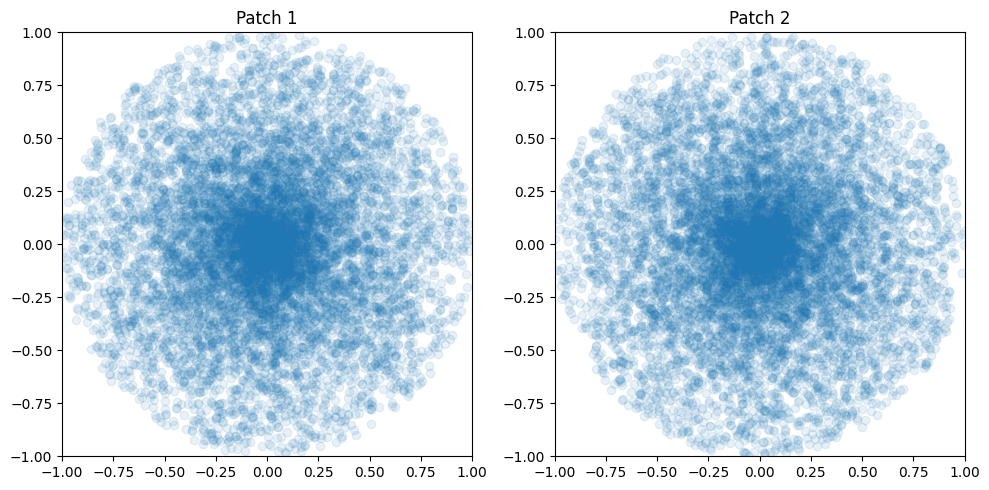

In [43]:
# Define the test sample hyperparameters and generate it
dim = loaded_model.dim
num_samples = int(1e4)
density_power = 1.  # ...the \alpha (>0) value in the beta function, values < 1 skew to extremeties, >1 skew to centre
patch_width = 1.    #...the radii of the patches considered

# Generate the test data
test_samples = [tf.convert_to_tensor(BallSample(
        num_samples, dimension=dim, patch_width=patch_width, density_power=density_power))]
# If the model is 2-patch copy the test data to the 2nd patch also
if loaded_model.n_patches > 1:
    test_samples.append(PatchChange_Coordinates_Ball(test_samples[0]))

# Plot the sample
fig, axes = plt.subplots(1, loaded_model.n_patches, figsize=(5*loaded_model.n_patches, 5))
if loaded_model.n_patches == 1:
    axes = [axes]
for i in range(loaded_model.n_patches):
    axes[i].set_title(f'Patch {i+1}')
    axes[i].scatter(test_samples[i][:,0], test_samples[i][:,1], alpha=0.1)
    axes[i].set_xlim(-1,1)
    axes[i].set_ylim(-1,1)
plt.tight_layout()

# Print warning that we consider only a section if dim > 2
if dim != 2:
    print(f'...note these images are 2d sections of the {dim}d patches!')


In [44]:
# Predict the metric and the Ricci on the test sample in both patches
# predicted_vielbeins = [loaded_model.patch_submodels[patch_idx].predict(test_samples[patch_idx]) for patch_idx in range(loaded_model.n_patches)]
# predicted_metrics = [cholesky_from_vec(predicted_vielbeins[patch_idx]).numpy() for patch_idx in range(loaded_model.n_patches)]
# predicted_riccis = [compute_ricci_tensor(test_samples[patch_idx], loaded_model.patch_submodels[patch_idx]).numpy() for patch_idx in range(loaded_model.n_patches)]
# Predict the metric and compute the scalar curvature for the test sample in both patches.

# Directly call the patch_submodels as functions. The output is already the Cholesky vector.
predicted_cholesky_vecs = [
    loaded_model.patch_submodels[patch_idx](test_samples[patch_idx]) 
    for patch_idx in range(loaded_model.n_patches)
]

# Convert the Cholesky vectors to full metric matrices
predicted_metrics = [
    cholesky_from_vec(vec).numpy() for vec in predicted_cholesky_vecs
]

# Compute the scalar curvature which is the relevant quantity for your new model
# We need to import compute_scalar_curvature
from geometry.common import compute_scalar_curvature 

predicted_scalar_curvatures = [
    compute_scalar_curvature(test_samples[patch_idx], loaded_model.patch_submodels[patch_idx]).numpy()
    for patch_idx in range(loaded_model.n_patches)
]

Saving plot to results_5cos3_1.pdf...


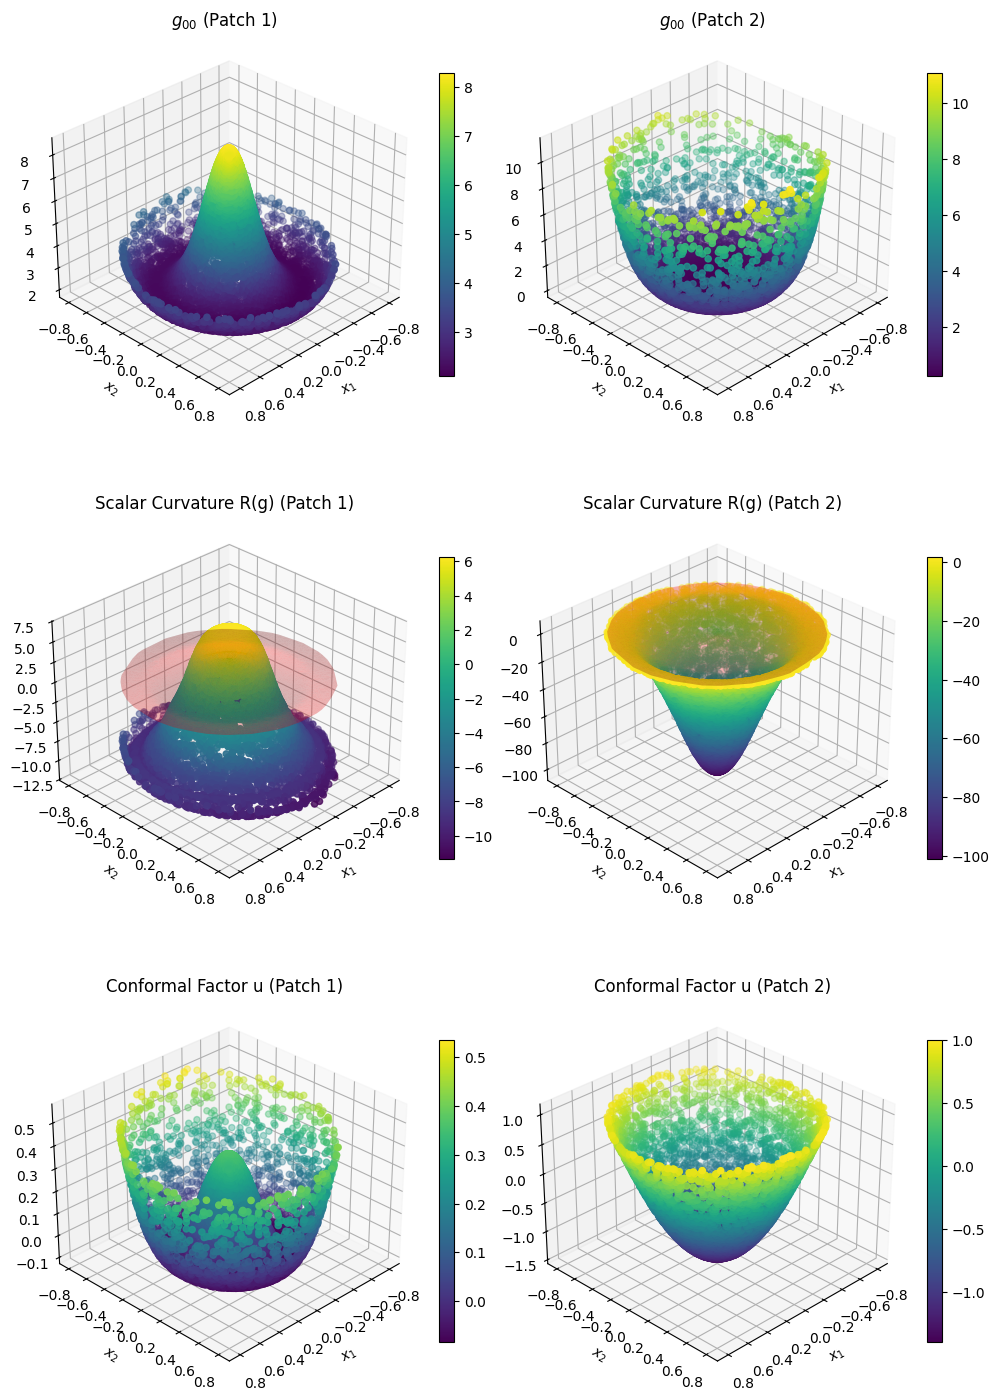

In [45]:
# Plotting: examine the trained metric, scalar curvature, and conformal factor u

# --- Set the plotting hyperparameters ---
# Choose the metric component to plot (e.g., 0,0 for g_11)
metric_index_1, metric_index_2 = 0, 0 
# Select the input dimensions to plot
dim_x, dim_y = 0, 1
# Range limit for plotting to avoid numerical instabilities at the patch edge
plot_radial_limit = 0.8
# Filename to save the plot as a PDF, set to None to disable saving
save_pdf_filename = f'results_{loaded_model.hp["K_kind"]}.pdf'

# --- Setup the plots ---
# We will create a 3-row figure: Metric, Scalar Curvature, and Conformal Factor u
elevation_angle, azimuth_angle = 30, 45
fig, axes = plt.subplots(3, loaded_model.n_patches, figsize=(5 * loaded_model.n_patches, 15), subplot_kw={'projection': '3d'})
if loaded_model.n_patches == 1:
    axes = np.expand_dims(axes, -1)

# --- Restrict the data to the plotting radius ---
if plot_radial_limit < patch_width:
    masks = [tf.sqrt(tf.reduce_sum(tf.square(ts), axis=-1)) < plot_radial_limit for ts in test_samples]
    test_samples_limited = [tf.boolean_mask(test_samples[p_idx], masks[p_idx]) for p_idx in range(loaded_model.n_patches)]
    predicted_metrics_limited = [tf.boolean_mask(predicted_metrics[p_idx], masks[p_idx]) for p_idx in range(loaded_model.n_patches)]
    # Use the scalar curvatures we calculated in the previous cell
    predicted_scalar_curvatures_limited = [tf.boolean_mask(predicted_scalar_curvatures[p_idx], masks[p_idx]) for p_idx in range(loaded_model.n_patches)]
else:
    test_samples_limited = test_samples
    predicted_metrics_limited = predicted_metrics
    predicted_scalar_curvatures_limited = predicted_scalar_curvatures

# --- Plot Row 1: Metric Component (g_ij) ---
for i in range(loaded_model.n_patches):
    ax = axes[0, i]
    data_to_plot = predicted_metrics_limited[i][:, metric_index_1, metric_index_2]
    scatter = ax.scatter(test_samples_limited[i][:, dim_x], test_samples_limited[i][:, dim_y],
                         data_to_plot, c=data_to_plot, cmap="viridis")
    ax.set_title(rf"$g_{{{metric_index_1}{metric_index_2}}}$ (Patch {i+1})")
    ax.set_xlabel(r'$x_1$')
    ax.set_ylabel(r'$x_2$')
    fig.colorbar(scatter, ax=ax, shrink=0.6)
    ax.view_init(elev=elevation_angle, azim=azimuth_angle)

# --- Plot Row 2: Scalar Curvature (R) ---
# Also plot the target K function for comparison
from geometry.ball import prescribed_K, patch_xy_to_xyz
target_K_limited = [prescribed_K(ts, kind=loaded_model.hp["K_kind"], patch_idx=i) for i, ts in enumerate(test_samples_limited)]

for i in range(loaded_model.n_patches):
    ax = axes[1, i]
    # Plot the predicted scalar curvature
    data_to_plot = predicted_scalar_curvatures_limited[i]
    scatter = ax.scatter(test_samples_limited[i][:, dim_x], test_samples_limited[i][:, dim_y],
                         data_to_plot, c=data_to_plot, cmap="viridis", label="Predicted R(g)")
    # Overlay the target K function as a surface or wireframe for comparison
    ax.plot_trisurf(test_samples_limited[i][:, dim_x], test_samples_limited[i][:, dim_y],
                    target_K_limited[i], color='red', alpha=0.3, label="Target K")
    
    ax.set_title(f"Scalar Curvature R(g) (Patch {i+1})")
    ax.set_xlabel(r'$x_1$')
    ax.set_ylabel(r'$x_2$')
    fig.colorbar(scatter, ax=ax, shrink=0.6)
    ax.view_init(elev=elevation_angle, azim=azimuth_angle)

# --- Plot Row 3: Conformal Factor (u) ---
# To get u, we need to evaluate the model's internal u_model
u_vals_limited = []
for i in range(loaded_model.n_patches):
    xyz_coords = patch_xy_to_xyz(test_samples_limited[i], patch_idx=i)
    u_vals = loaded_model.u_model(xyz_coords)
    u_vals_limited.append(tf.squeeze(u_vals, axis=-1).numpy())
    
for i in range(loaded_model.n_patches):
    ax = axes[2, i]
    data_to_plot = u_vals_limited[i]
    scatter = ax.scatter(test_samples_limited[i][:, dim_x], test_samples_limited[i][:, dim_y],
                         data_to_plot, c=data_to_plot, cmap="viridis")
    ax.set_title(f"Conformal Factor u (Patch {i+1})")
    ax.set_xlabel(r'$x_1$')
    ax.set_ylabel(r'$x_2$')
    fig.colorbar(scatter, ax=ax, shrink=0.6)
    ax.view_init(elev=elevation_angle, azim=azimuth_angle)

# --- Finalize and Save ---
plt.tight_layout()
save_filename = f'results_{loaded_model.hp["K_kind"]}.pdf'
if save_filename:
    print(f"Saving plot to {save_filename}...")
    # dpi controls the resolution (dots per inch)
    plt.savefig(save_filename, dpi=300) 

plt.show()

In [ ]:
# Compute the Global test loss
# Set the radial limit for each patch
radial_midpoint = np.sqrt(3. - 2 * np.sqrt(2.))
rl = radial_midpoint + 0.1

# Define the loss
global_loss = GlobalLossBall(loaded_model.hp, radial_limit=rl)

# Compute the full network output on the test sample
metric_pred = loaded_model.predict(test_samples[0])

# Compute the losses, and print
global_loss_value, global_loss_data, global_sample_sizes = global_loss.call(loaded_model, test_samples[0], metric_pred)
print(f'Global loss: {global_loss_value}\nLoss data:\n{global_loss_data}\nSample sizes ([patches], overlap): {global_sample_sizes}')


In [ ]:
# Plot the analytic metrics 
identity_bool = False #...select whether the analytic metric is the identity non-geometric metric (True), or round metric (False)

# Compute the analytic metrics on the test data
analytic_metrics = [AnalyticMetric_Ball(test_samples[patch_idx], identity=identity_bool) for patch_idx in range(loaded_model.n_patches)]

# Choose the metric component to plot
metric_index_1, metric_index_2 = 0, 0

# Setup the plots
elevation_angle, azimuth_angle = 30, 45 #...set the orientation of the 3d plots
fig, axes = plt.subplots(1, loaded_model.n_patches, figsize=(5*loaded_model.n_patches, 5), subplot_kw={'projection': '3d'})
if loaded_model.n_patches == 1:
    axes = [axes]

# Plot the metric component in each patch
for i in range(loaded_model.n_patches):
    axes[i].scatter(test_samples[i][:,dim_x], test_samples[i][:,dim_y],
            analytic_metrics[i][:, metric_index_1, metric_index_2],
            c=analytic_metrics[i][:, metric_index_1, metric_index_2],
            cmap="viridis")
    axes[i].set_title(rf"$g_{{{metric_index_1},{metric_index_2}}}$ Analytic (patch {i+1})")
    axes[i].set_xlabel(r'$x_1$')
    axes[i].set_ylabel(r'$x_2$')
    axes[i].view_init(elev=elevation_angle, azim=azimuth_angle) 

plt.tight_layout()